# MCO3
S13 - Group 2
1.   Bryce Andrei C. Miranda
2.   Ron William M. Cajumban
3.   Timothy Robert P. Bacud





# Introduction

In this Machine Learning (ML) Paper, the researchers aim to utilize a dataset of most streamed blues Spotify songs to recognize what made a song popular; using the "Track Score" feature found in Spotify. Track score is the value that measures the popularity metric for each track. According to Kaggle, the track score is a value that depends on multiple features attributed to a track. It is unknown how a track score is rated even in Spotify's features; Thus by utilizing pre-existing features and running the data through a ML model, it is possible to ascertain the rules that make up Spotify's track score.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, KBinsDiscretizer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from scipy import stats


# Dataset

## Pre-Processing of data



The researchers used the following data from Kaggle:
https://www.kaggle.com/datasets/nelgiriyewithana/most-streamed-spotify-songs-2024/data.

In [ ]:
df = pd.read_csv('data.csv', encoding='latin-1')
df = df[['Track', 'Album Name', 'Artist', 'Release Date', 'All Time Rank', 'Track Score', 'Spotify Streams', 'Spotify Playlist Count', 'Spotify Playlist Reach', 'Spotify Popularity', 'YouTube Views', 'TikTok Views', 'Soundcloud Streams', 'Pandora Streams', 'Shazam Counts', 'AirPlay Spins', 'Explicit Track']]
df.columns = df.columns.str.strip()

numerical_columns = [
    'All Time Rank', 'Track Score', 'Spotify Streams', 'YouTube Views', 'TikTok Views', 'Soundcloud Streams', 'Pandora Streams', 'Shazam Counts', 'AirPlay Spins'
]

for column in numerical_columns:
    df[column] = df[column].astype(str).str.replace(',', '').astype(float)

df.fillna(0, inplace=True)

# Extract relevant columns
X = df[['Spotify Streams', 'YouTube Views', 'TikTok Views', 'Soundcloud Streams', 'Pandora Streams', 'Shazam Counts', 'AirPlay Spins']]
y = df['Track Score']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Importing Data and Selecting Significant Features
The code reads data from the data.csv file which contains data attributed to Spotify.
The next line of code selects specific columns of interest, which are namely the track, the album it is in, the artist who produced the track, the date of its release, the track's all time rank, its track score, the amount of plays/streams in spotify, youtube, tik-tok, soundcloud, and pandora, the amount of times the track is found in a user's playlist, the amount of times the playlist is accessed by other users, and finally if the track is an explicit track.

In [ ]:
df = pd.read_csv('data.csv', encoding='latin-1')
df = df[['Track', 'Album Name', 'Artist', 'Release Date', 'All Time Rank', 'Track Score', 'Spotify Streams', 'Spotify Playlist Count', 'Spotify Playlist Reach', 'Spotify Popularity', 'YouTube Views', 'TikTok Views', 'Soundcloud Streams', 'Pandora Streams', 'Shazam Counts', 'AirPlay Spins', 'Explicit Track']]
df.columns = df.columns.str.strip()

## Assigning Numerical Columns

A list is produced that lists down what columns are deemed quantifiable. Notably, the track's all-time rank, track score, spotify/youtube/soundcloud/pandora/shazam/airplay plays/streams which will then be converted to an appropriate data type (float). The next line strips any whitespace from the numerical column names.

In [ ]:
numerical_columns = [
    'All Time Rank', 'Track Score', 'Spotify Streams', 'YouTube Views', 'TikTok Views', 'Soundcloud Streams', 'Pandora Streams', 'Shazam Counts', 'AirPlay Spins'
]

for column in numerical_columns:
    df[column] = df[column].astype(str).str.replace(',', '').astype(float)

## Null Checking and Replacing
The code checks if there are any missing values per track and replaces the missing values with 0 to avoid null returns.

In [ ]:
df.fillna(0, inplace=True)

## Categorizing Columns and Training

The code then extracts the relevant columns that will be used for training the model, which will be then split accordingly. The features DataFrame includes all columns except the target column (Spotify Popularity). The target Series includes only the Spotify Track Score column, which is what we want to predict. We would want a 70-30 data split where 70% of the data is used for training and 30% of the data will be used for testing. The random stat 42 Ensures reproducibility by setting a seed for the random number generator

In [ ]:
# Extract relevant columns
X = df[['Spotify Streams', 'YouTube Views', 'TikTok Views', 'Soundcloud Streams', 'Pandora Streams', 'Shazam Counts', 'AirPlay Spins']]
y = df['Track Score']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Methodology

## Data Standardization and Model Training

This notebook demonstrates the process of cleaning, standardizing, and training a Gaussian Naive Bayes model on a dataset.

In [ ]:
# Standardize the data
def clean_and_convert(df):
    df = df.copy()
    for column in df.columns:
        if df[column].dtype == 'object':
            df.loc[:, column] = df[column].str.replace(',', '')
            df.loc[:, column] = pd.to_numeric(df[column], errors='coerce')
    return df

train_data = pd.concat([X_train, y_train], axis=1)

z_scores = np.abs(stats.zscore(X_train))
train_data_clean = train_data[(z_scores < 3).all(axis=1)]
X_train_clean = X_train[(z_scores < 3).all(axis=1)]
y_train_clean = y_train[(z_scores < 3).all(axis=1)]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Check for NaN values
print(f"NaN values in y_train: {y_train.isna().sum()}")

# Handle NaN values if any
if y_train.isna().sum() > 0:
    y_train = y_train.dropna()
    X_train = X_train.loc[y_train.index]
    X_train_scaled = scaler.fit_transform(X_train)

# Ensure consistent sample sizes
assert X_train_scaled.shape[0] == y_train.shape[0], "Inconsistent number of samples between X_train and y_train"

# Binning the target variable
n_bins = 10  # Define the number of bins
kbins = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')

# Fit and transform the training and testing target data
y_train_binned = kbins.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_binned = kbins.transform(y_test.values.reshape(-1, 1)).ravel()

# Train the Gaussian Naive Bayes model
nb_model = GaussianNB()
nb_model.fit(X_train_scaled, y_train_binned)
y_pred = nb_model.predict(X_test_scaled)




NaN values in y_train: 0


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


## Data Cleaning and Conversion
First, The researchers defined a function to clean and convert the data. This function removes commas from string columns and converts them to numeric values.

In [ ]:
# Standardize the data
def clean_and_convert(df):
    df = df.copy()
    for column in df.columns:
        if df[column].dtype == 'object':
            df.loc[:, column] = df[column].str.replace(',', '')
            df.loc[:, column] = pd.to_numeric(df[column], errors='coerce')
    return df

## Combine Training Data

Next, the code combines the features (`X_train`) and target (`y_train`) into a single DataFrame for easier processing.

In [ ]:
train_data = pd.concat([X_train, y_train], axis=1)

## Remove Outliers

The code then calculate the z-scores of the training data and remove any rows where the z-score is greater than 3, which helps in removing outliers.

In [ ]:
z_scores = np.abs(stats.zscore(X_train))
train_data_clean = train_data[(z_scores < 3).all(axis=1)]
X_train_clean = X_train[(z_scores < 3).all(axis=1)]
y_train_clean = y_train[(z_scores < 3).all(axis=1)]

## Standardize Features

The researchers use the `StandardScaler` to standardize the features in the training and test datasets.

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Handle Missing Values

If there are any NaN values in the target variable (`y_train`), those rows are dropped and ensured the feature set (`X_train`) is consistent with the target variable.

In [ ]:
# Handle NaN values if any
if y_train.isna().sum() > 0:
    y_train = y_train.dropna()
    X_train = X_train.loc[y_train.index]
    X_train_scaled = scaler.fit_transform(X_train)

## Ensure Consistent Sample Sizes

The code will then assert that the number of samples in the standardized training features matches the number of samples in the target variable.

In [ ]:
# Ensure consistent sample sizes
assert X_train_scaled.shape[0] == y_train.shape[0], "Inconsistent number of samples between X_train and y_train"

## Binning the Target Variable

The researchers used `KBinsDiscretizer` to bin the target variable into a specified number of bins. This helps in transforming continuous target values into discrete bins.

In [ ]:
# Binning the target variable
n_bins = 10  # Define the number of bins
kbins = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')

# Fit and transform the training and testing target data
y_train_binned = kbins.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_binned = kbins.transform(y_test.values.reshape(-1, 1)).ravel()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


## Train the Gaussian Naive Bayes Model

Finally, we train a Gaussian Naive Bayes model using the standardized training features and the binned target variable. We then use the trained model to make predictions on the test data.

In [ ]:
# Train the Gaussian Naive Bayes model
nb_model = GaussianNB()
nb_model.fit(X_train_scaled, y_train_binned)
y_pred = nb_model.predict(X_test_scaled)

## Confusion Matrix

The researchers then plotted a confusion matrix based on the trained model where the Y-axis is the actual data while the X-axis is the predicted data by running the actual data through the model.

Confusion Matrix:
[[694  57  10  16 484  17   1]
 [ 35  15   4   6   7   5   0]
 [  7   2   3   3   1   1   0]
 [  2   1   2   2   0   2   0]
 [  1   0   0   0   1   0   0]
 [  0   1   0   0   0   0   0]
 [  0   0   0   0   0   0   0]]


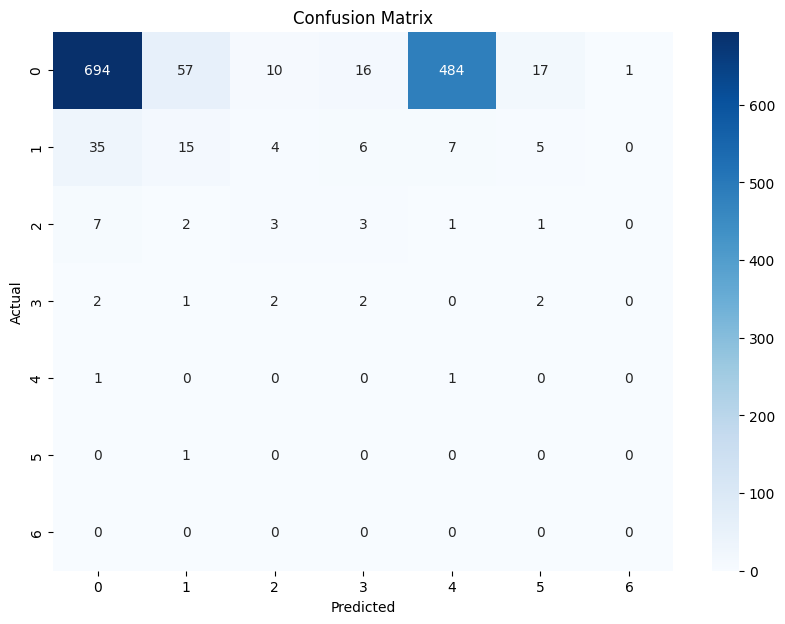

In [ ]:
# Evaluate the model using a confusion matrix
conf_matrix = confusion_matrix(y_test_binned, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Print additional evaluation metrics
print("\nClassification Report:")
print(classification_report(y_test_binned, y_pred, zero_division=1))
print("\nAccuracy Score:")
print(accuracy_score(y_test_binned, y_pred))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.54      0.69      1279
         1.0       0.20      0.21      0.20        72
         2.0       0.16      0.18      0.17        17
         3.0       0.07      0.22      0.11         9
         4.0       0.00      0.50      0.00         2
         5.0       0.00      0.00      1.00         1
         7.0       0.00      1.00      0.00         0

    accuracy                           0.52      1380
   macro avg       0.20      0.38      0.31      1380
weighted avg       0.88      0.52      0.65      1380


Accuracy Score:
0.5181159420289855


## Good Features
 If the correlation analysis shows a significant relationship between the features and the target, and the model evaluation shows good performance, then these features are likely good predictors.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(


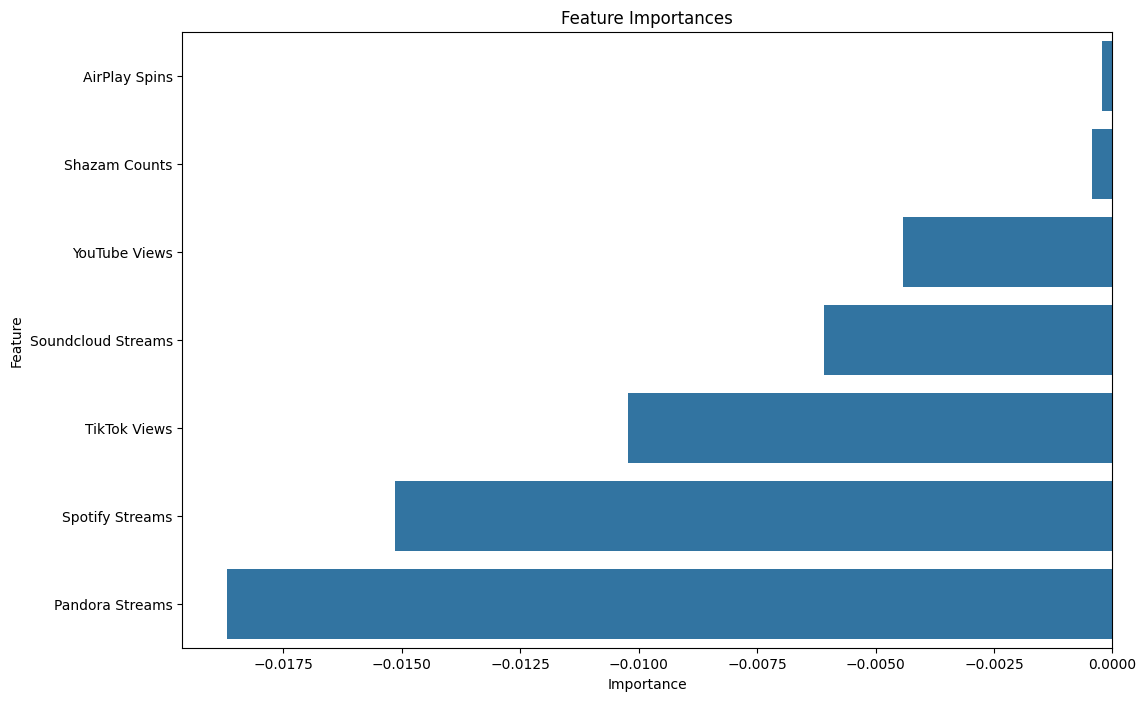

In [ ]:

result = permutation_importance(nb_model, X_test, y_test_binned, n_repeats=10, random_state=42, n_jobs=-1)
# Create a dataframe with feature names and importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': result.importances_mean})
# Sort the dataframe by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


The popularity of Spotify tracks can be significantly influenced by their presence on TikTok. When a song is used in a viral TikTok video, it often leads to a surge in likes, views, and posts on the platform. This increased visibility can translate to higher streaming numbers on Spotify, as users seek out the full track after encountering it on TikTok. The correlation between TikTok activity and Spotify popularity underscores the power of social media in shaping music trends and driving listener engagement. As a result, artists and marketers are increasingly leveraging TikTok to boost their tracks' performance on streaming platforms like Spotify.

## Classification Report

In [ ]:

# Print classification report and accuracy
print("Classification Report:")
print(classification_report(y_test_binned, y_pred, zero_division=1))

accuracy = accuracy_score(y_test_binned, y_pred)
print(f'Accuracy: {accuracy}')


Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.54      0.69      1279
         1.0       0.20      0.21      0.20        72
         2.0       0.16      0.18      0.17        17
         3.0       0.07      0.22      0.11         9
         4.0       0.00      0.50      0.00         2
         5.0       0.00      0.00      1.00         1
         7.0       0.00      1.00      0.00         0

    accuracy                           0.52      1380
   macro avg       0.20      0.38      0.31      1380
weighted avg       0.88      0.52      0.65      1380

Accuracy: 0.5181159420289855



The Accuracy Indicates that 50% of the total predictions were correct.
Our Macro Average provides an sub-average performance metric that treats all classes equally, showing a balanced view of the model's performance across all classes.
Our Weighted Average provides an average performance metric that takes into account the number of instances for each class, giving a more realistic view of the model's performance, especially when the class distribution is imbalanced.


# Results and Analysis

## Model Performance

Based on the results, the Gaussian Naive-Bayes Model gave out an accuracy of 52% as indicated by the classification report and the confusion matrix. The confusion matrix achieved the following:


*   Majority of correct items are rated as 0
*   The model struggling to predict higher track scores, with precision and recall values significantly dropping after the score of 1.



## Confusion Matrix amd Classification Report

For the Confusion Matrix, most of the predictions were found around the lower track scores, with higher track scores being less predicted and oftentimes predicted incorrectly. The weighted average for precision, recall, and F1 score were 0.88, 0.52, and 0.65 respectively. These tells us that the Model is good at predicting lower overall scores, but struggles to compute for the ones that are rated higher.

## Recommendations

To potentially enhance the performance of the model, the researchers suggest the inclusion of more relevant features, or transform existing ones. Furthermore, a more complex model is needed for data that are similar to the one analyzed in this study. Finally, a more balanced dataset can give more procedureally balanced results.



# Conclusion

In conclusion, this Machine Learning study demonstrated the process of cleaning, standardizing then training a Gaussian Naive-Bayes model. The model gave an accuracy of 52%, showcasing the complexity and unpredictability of track popularity or track score. The findings shows the significant impact of other platforms, most notably **Tik-Tok**, being a strong indicator for a song's popularity. This underscores the importance of leveraging social media to enhance music visibility and engagement in the streaming era.